In [1]:
import numpy as np
import pandas as pd

from palmerpenguins import load_penguins

In [2]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax

In [3]:
penguins = load_penguins()

In [4]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


In [5]:
penguins.count()

species              344
island               344
bill_length_mm       342
bill_depth_mm        342
flipper_length_mm    342
body_mass_g          342
sex                  333
year                 344
dtype: int64

In [6]:
# drop NaN

penguins = penguins.dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,male,2007


In [7]:
feature_columns = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
target_column = "species"

features = penguins[feature_columns].values
targets = penguins[target_column].values

In [8]:
# target label dict
target_ids_dict = dict()

unique_target_labels = set(targets)
_id = 0
for ul in unique_target_labels:
    target_ids_dict[ul] = _id
    _id += 1
    
target_ids_dict

{'Adelie': 0, 'Gentoo': 1, 'Chinstrap': 2}

In [9]:
from tqdm.notebook import tqdm

# convert target labels to integers using the same dict


def convert_label_to_ids(targets, id_dict):
    converted_targets = np.zeros(shape=(len(targets, )), dtype=np.int32)
    for idx, target in tqdm(enumerate(targets)):
        converted_targets[idx] = id_dict[target]

    return converted_targets


targets_converted = convert_label_to_ids(targets=targets, id_dict=target_ids_dict)

0it [00:00, ?it/s]

In [10]:
assert features.shape[0] == targets_converted.shape[0]

In [11]:
from sklearn import preprocessing

features_norm = preprocessing.normalize(features, norm="l2")

In [12]:
# create train test split. Dataset is pretty small so can't really make a validation set here
from sklearn.model_selection import train_test_split

features_train, features_test, targets_train, targets_test = train_test_split(
    features_norm, targets_converted, test_size=0.3, random_state=42)

In [13]:
features_train = jnp.array(features_train)
features_test = jnp.array(features_test)
targets_train = jnp.array(targets_train)
targets_test = jnp.array(targets_test)

In [14]:
print(f"Train Size : {features_train.shape[0]}")
print(f"Test Size: {features_test.shape[0]}")

Train Size : 233
Test Size: 100


In [15]:
class PenguinFinder(nn.Module):
    in_features: int =  4 # 4 columns with features to classify penguins
    hidden_dim: int = 4
    out_dim: int = 3 # number of classes
        
    @nn.compact
    def __call__(self, x):
        out = nn.Dense(features=self.in_features)(x)
        out = nn.Dense(features=self.hidden_dim)(out)
        out = nn.leaky_relu(out)
        
        # apply softmax
        logits = jax.nn.softmax(out)
        
        return logits

In [16]:
rng = jax.random.PRNGKey(42)

model = PenguinFinder()
params = model.init(rng, features_train[0])

In [17]:
params

FrozenDict({
    params: {
        Dense_0: {
            kernel: DeviceArray([[-0.08309741,  0.62912625, -0.16815168,  0.16308075],
                         [ 0.08364423,  0.48755625,  0.7825095 , -0.15177737],
                         [-0.66532636,  0.11095859, -0.07868695, -0.5322201 ],
                         [ 0.5642229 ,  0.57618606, -0.4533119 , -0.18674311]],            dtype=float32),
            bias: DeviceArray([0., 0., 0., 0.], dtype=float32),
        },
        Dense_1: {
            kernel: DeviceArray([[ 0.01293683, -0.1283617 , -0.00723918, -0.0592929 ],
                         [-0.79303294,  0.741729  ,  0.22723791, -0.20607322],
                         [ 0.11693704,  0.6277427 , -0.20141304,  0.51093733],
                         [ 0.9667059 , -0.01717042,  0.25071916,  0.40597463]],            dtype=float32),
            bias: DeviceArray([0., 0., 0., 0.], dtype=float32),
        },
    },
})

In [18]:
model.apply(params, features_train[0])

DeviceArray([0.23273471, 0.25657552, 0.27736816, 0.23332164], dtype=float32)

In [19]:
@jax.jit
def cross_entropy(params, x, y):
    logits = model.apply(params, x)
    return -jnp.log(logits[y])

In [20]:
cross_entropy(params, features_train[0], targets_train[0])

DeviceArray(1.457856, dtype=float32)

In [21]:
@jax.jit
def calculate_loss(params, xs, ys):
    return jnp.mean(
        jax.vmap(cross_entropy, in_axes=(None, 0, 0))(params, xs, ys)
    )

In [22]:
calculate_loss(params, features_train, targets_train)

DeviceArray(1.3876096, dtype=float32)

In [23]:
from tqdm.notebook import trange
from flax.training import train_state

lr = 0.1
optimizer = optax.adam(learning_rate=lr)
# opt_state = tx.init(params)
loss_grad_fn = jax.value_and_grad(calculate_loss) 


model_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx = optimizer
)



@jax.jit
def train_step(state, xs, ys):
    loss_value, grads = loss_grad_fn(state.params, xs, ys)
    state = state.apply_gradients(grads=grads)
    return loss_value, state


def train_model(state, xs, ys, epochs=1000):
    losses = list()
    steps = list()
    
    step_count = 0
    
    for e in trange(epochs):
        loss, state = train_step(state, xs, ys)
        if step_count % 50 == 0:
            losses.append(loss)
            steps.append(step_count)
        step_count += 1
        
    return state, losses, steps

In [24]:
trained_model_state, losses, steps = train_model(state=model_state, xs=features_train, ys=targets_train)

  0%|          | 0/1000 [00:00<?, ?it/s]

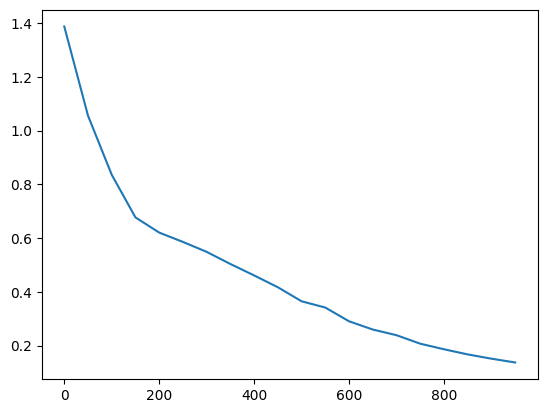

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


sns.lineplot(x=np.array(steps), y=np.array(losses))
plt.show()

In [26]:
@jax.jit
def test_step(state, x):
    logits = model.apply(state.params, x)
    out = jnp.argmax(logits, axis=-1)
    
    return out
    

@jax.jit
def test(state, xs):
    return jax.vmap(test_step, in_axes=(None, 0))(state, xs)

In [27]:
predictions = test(trained_model_state, features_test) 

In [28]:
from sklearn.metrics import classification_report

report = classification_report(y_pred=predictions, y_true=targets_test)
print(report)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95        48
           1       1.00      0.97      0.98        29
           2       1.00      0.83      0.90        23

    accuracy                           0.95       100
   macro avg       0.97      0.93      0.95       100
weighted avg       0.95      0.95      0.95       100

